<a href="https://colab.research.google.com/github/alphaameer007/RHM_FYP/blob/main/TCN_Model_on_Turkey_Wind_Farm_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install keras-tcn --no-dependencies 

In [ ]:
from tcn import TCN
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense

In [ ]:
df=pd.read_csv('/kaggle/input/t2csv/T2.csv')
df

,time,LV ActivePower (kW),Wind Speed (m/s),wind energy,Wind Direction (°)
0,1/1/2018 0:00,380.047791,5.311336,416.328908,259.994904
1,1/1/2018 0:10,453.769196,5.672167,519.917511,268.641113
2,1/1/2018 0:20,306.376587,5.216037,390.900016,272.564789
3,1/1/2018 0:30,419.645904,5.659674,516.127569,271.258087
4,1/1/2018 0:40,380.650696,5.577941,491.702972,265.674286
...,...,...,...,...,...
52555,12/31/2018 23:10,2963.980957,11.404030,3397.190793,80.502724
52556,12/31/2018 23:20,1684.353027,7.332648,1173.055771,84.062599
52557,12/31/2018 23:30,2201.106934,8.435358,1788.284755,84.742500
52558,12/31/2018 23:40,2515.694092,9.421366,2418.382503,84.297913


In [ ]:
df.drop('time', inplace=True, axis=1)

In [ ]:
df

,LV ActivePower (kW),Wind Speed (m/s),wind energy,Wind Direction (°)
0,380.047791,5.311336,416.328908,259.994904
1,453.769196,5.672167,519.917511,268.641113
2,306.376587,5.216037,390.900016,272.564789
3,419.645904,5.659674,516.127569,271.258087
4,380.650696,5.577941,491.702972,265.674286
...,...,...,...,...
52555,2963.980957,11.404030,3397.190793,80.502724
52556,1684.353027,7.332648,1173.055771,84.062599
52557,2201.106934,8.435358,1788.284755,84.742500
52558,2515.694092,9.421366,2418.382503,84.297913


In [ ]:
max_values = df.max()              #normalizing data in between range [0,1]
df = df.div(max_values) 

In [ ]:
df

,LV ActivePower (kW),Wind Speed (m/s),wind energy,Wind Direction (°)
0,0.105022,0.210717,0.115647,0.722213
1,0.125394,0.225032,0.144422,0.746230
2,0.084664,0.206936,0.108583,0.757129
3,0.115965,0.224537,0.143369,0.753500
4,0.105189,0.221294,0.136584,0.737989
...,...,...,...,...
52555,0.819066,0.452433,0.943664,0.223620
52556,0.465454,0.290909,0.325849,0.233509
52557,0.608253,0.334657,0.496746,0.235397
52558,0.695186,0.373775,0.671773,0.234162


In [ ]:
target=df['LV ActivePower (kW)']
target.shape

(52560,)

In [ ]:
# Calculate the number of readings per day
readings_per_day = 144

#n = number of day
n = 3

# Calculate the sequence length (n days in readings)
sequence_length = readings_per_day * n

# Set the lookback window to be the same as the sequence length
lookback_window = sequence_length

# Convert the data to a NumPy array
df = df.values

x, y = [], []
for i in range(lookback_window, len(df)):
    x.append(df[i - lookback_window:i, :])
    y.append(df[i, -1])
x = np.array(x)
y = np.array(y)

In [ ]:
print(x.shape)
print(y.shape)

(52128, 432, 4)
(52128,)


In [ ]:
# Calculate the number of test samples (last 3 days of the year)
num_test_samples = readings_per_day * 3

# Split the data into training and test sets
x_train = x[:-num_test_samples]
y_train = y[:-num_test_samples]
x_test = x[-num_test_samples:]
y_test = y[-num_test_samples:]

In [ ]:
model = keras.models.Sequential([
    TCN(input_shape=(lookback_window, 4), 
        kernel_size=10,
        nb_filters=32,
        dilations=[1, 2, 4, 8, 16],
        padding='causal',
        activation='relu',
        return_sequences=False,
        nb_stacks=4,
        use_skip_connections=False,
        use_batch_norm=False
        ),
    keras.layers.Dense(1)
])
model.summary()
model.compile('adam', 'mae',metrics=keras.metrics.MeanAbsolutePercentageError())

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
tcn_9 (TCN)                  (None, 32)                402080    
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 33        
Total params: 402,113
Trainable params: 402,113
Non-trainable params: 0
_________________________________________________________________


In [ ]:
print('Train...')
history = model.fit(x_train, y_train,
                    epochs=50,
                    verbose=1)

Train...
Epoch 1/50
1616/1616 [==============================] - 58s 33ms/step - loss: 11.4518 - mean_absolute_percentage_error: 6755.3457
Epoch 2/50
1616/1616 [==============================] - 53s 33ms/step - loss: 0.1434 - mean_absolute_percentage_error: 210.2987
Epoch 3/50
1616/1616 [==============================] - 52s 32ms/step - loss: 0.0945 - mean_absolute_percentage_error: 170.9978
Epoch 4/50
1616/1616 [==============================] - 52s 32ms/step - loss: 0.0720 - mean_absolute_percentage_error: 164.6912
Epoch 5/50
1616/1616 [==============================] - 52s 32ms/step - loss: 0.0576 - mean_absolute_percentage_error: 147.7433
Epoch 6/50
1616/1616 [==============================] - 51s 32ms/step - loss: 0.0476 - mean_absolute_percentage_error: 142.6748
Epoch 7/50
1616/1616 [==============================] - 52s 32ms/step - loss: 0.0423 - mean_absolute_percentage_error: 138.9996
Epoch 8/50
1616/1616 [==============================] - 52s 32ms/step - loss: 0.0377 - mean_a

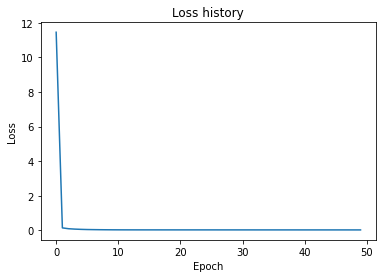

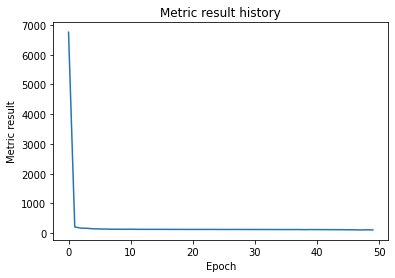

In [ ]:
import matplotlib.pyplot as plt

# Extract the history of loss and metric result from the history object
loss_history = history.history['loss']
mape_history = history.history['mean_absolute_percentage_error']

# Plot the history of loss
plt.plot(loss_history)
plt.title('Loss history')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# Plot the history of metric result
plt.plot(mape_history)
plt.title('Metric result history')
plt.xlabel('Epoch')
plt.ylabel('Metric result')
plt.show()


In [ ]:
p = model.predict(x_test)

In [ ]:
print(x_test.shape)
print(y_test.shape)
print(p.shape)

(432, 432, 4)
(432,)
(432, 1)


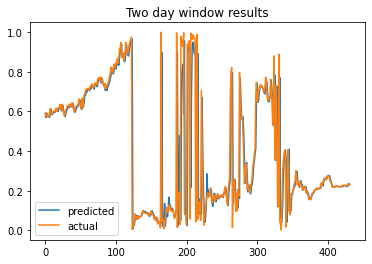

In [ ]:
p = model.predict(x_test)
plt.plot(p) #denormalizing prediction back
plt.plot(y_test) #denormalizing original data back
plt.title('Two day window results')
plt.legend(['predicted', 'actual'])
plt.show()